### Task 2

1. Fill in the missing data - embedded approach - median of the certain time during the day in previous days
2. Research "imputation time series" and "delayed coordinate embedding" and "delay coordinates"

#### Researched links
* https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7
* [Nonlinear Dynamics: Delay Coordinate Embedding](https://www.youtube.com/watch?v=eJB0kxpR4Rk)
* https://coledie.com/DelayCoordinateEmbeddings

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
### Get all the paths

paths = []

for root, dirs, files in os.walk("data", topdown=False):
   for name in files:
      paths.append(os.path.join(root, name))

In [49]:
def get_clean_dataframe(path):
    data = pd.read_csv(path)
    df = pd.DataFrame(data)
    df["Time"] = pd.to_datetime(df["Time"])
    df = df.drop_duplicates(subset=["Time"], keep=False)
    return df

In [9]:
def get_multiple_indexes(): 
    data = pd.read_csv(paths[0])
    df = pd.DataFrame(data)
    df["Time"] = pd.to_datetime(df["Time"])

    df = df.set_index("Time")

    non_unique_indices = df.index[df.index.duplicated()].tolist()

    return df[df.index.duplicated(keep=False)]

get_multiple_indexes()

,dt_sound_level_dB
Time,
2022-08-03 22:59:00,45
2022-08-03 22:59:00,48
2022-08-10 18:44:00,51
2022-08-10 18:44:00,55
2022-08-12 08:05:00,52
2022-08-12 08:05:00,53


In [104]:
def plot(path, timestamps, db_levels):    
    plt.figure(figsize=(16, 3))
    plt.step(timestamps, db_levels, label="SPL (dB)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
    plt.title(path)
    plt.xlabel("Time")
    plt.ylabel("Decibels (dB)")
    plt.grid(True)
    plt.xticks(rotation=90)
    y_min = db_levels.min()
    y_max = db_levels.max()
    y_ticks = np.arange(y_min, y_max, 1)
    plt.yticks(y_ticks)
    plt.legend()
    plt.show()

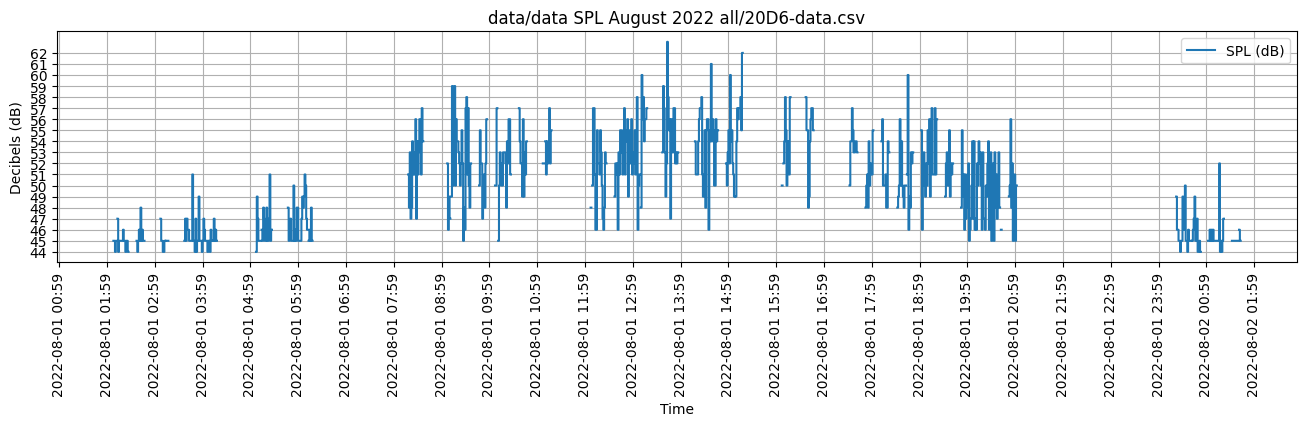

,Time,dt_sound_level_dB
0,2022-08-01 02:07:00,45.0
1,2022-08-01 02:08:00,45.0
2,2022-08-01 02:09:00,45.0
3,2022-08-01 02:10:00,44.0
4,2022-08-01 02:11:00,45.0
...,...,...
20028,2022-08-14 23:55:00,NaN
20029,2022-08-14 23:56:00,NaN
20030,2022-08-14 23:57:00,45.0
20031,2022-08-14 23:58:00,45.0


In [113]:
def get_one_sensor_24h_plot():
    df = get_clean_dataframe(paths[0])

    full_time_range = pd.date_range(start=df["Time"].min(), end=df["Time"].max(), freq="min")
    df = df.set_index("Time").reindex(full_time_range)
    df = df.rename_axis("Time").reset_index()

    df["time_diff"] = df["Time"].diff().dt.total_seconds()
    df["dt_sound_level_dB"] = np.where((df["time_diff"] == 60) | (df.index == 0), df["dt_sound_level_dB"], np.nan)
    df = df.drop(columns=["time_diff"])
    
    start_time = df["Time"].min()
    end_time = start_time + pd.Timedelta(hours=24)
    
    filtered_df = df[(df["Time"] >= start_time) & (df["Time"] < end_time)]
    
    plot(paths[0], filtered_df['Time'], filtered_df['dt_sound_level_dB'])

    return df

get_one_sensor_24h_plot()

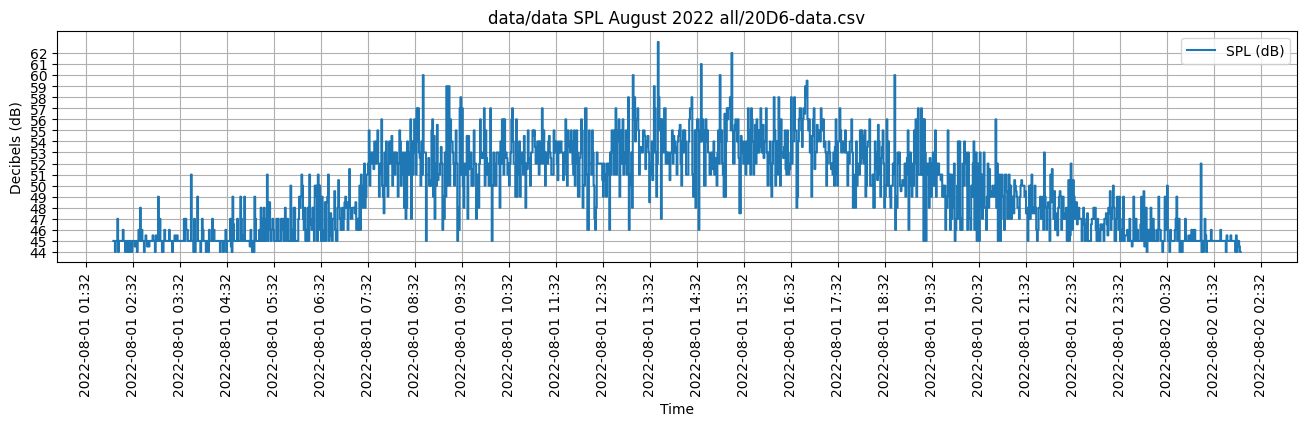

,Time,dt_sound_level_dB
0,2022-08-01 02:07:00,45.0
1,2022-08-01 02:08:00,45.0
2,2022-08-01 02:09:00,45.0
3,2022-08-01 02:10:00,44.0
4,2022-08-01 02:11:00,45.0
...,...,...
20028,2022-08-14 23:55:00,46.0
20029,2022-08-14 23:56:00,45.0
20030,2022-08-14 23:57:00,45.0
20031,2022-08-14 23:58:00,45.0


In [114]:
def get_one_sensor_24h_filled_plot(start_time, end_time):
    df = get_clean_dataframe(paths[0])

    all_possible_datetimes = pd.date_range(start=df["Time"].min(), end=df["Time"].max(), freq="min")
    df = df.set_index("Time").reindex(all_possible_datetimes)
    df = df.rename_axis("Time").reset_index()

    df["time_diff"] = df["Time"].diff().dt.total_seconds()
    df["dt_sound_level_dB"] = np.where((df["time_diff"] == 60) | (df.index == 0), df["dt_sound_level_dB"], np.nan)
    
    df["hour"] = df["Time"].dt.hour
    df["minute"] = df["Time"].dt.minute
    median_values = df.groupby(["hour", "minute"])["dt_sound_level_dB"].transform("median")
    df["dt_sound_level_dB"] = df["dt_sound_level_dB"].fillna(median_values)
    df = df.drop(columns=["time_diff", "hour", "minute"])
    
    start_time = df["Time"].min()
    end_time = start_time + pd.Timedelta(hours=24)
    
    filtered_df = df[(df["Time"] >= start_time) & (df["Time"] < end_time)]
    
    plot(paths[0], filtered_df['Time'], filtered_df['dt_sound_level_dB'])
    return df

get_one_sensor_24h_filled_plot()